# Previsión de la inflación mexicana mediante redes neuronales

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Importar pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [57]:
# Load the data
# Descargado de https://www.banxico.org.mx/SieInternet/consultarDirectorioInternetAction.do?accion=consultarCuadro&idCuadro=CP151&locale=en

path = 'data/Consulta_03.csv'
df = pd.read_csv(path, sep=',', encoding='utf-8')
columnas = df.columns  
df

,Fecha,Inflacion Indice de precios al consumidor (INPC) mensual,Inflacion Indice de precios al consumidor (INPC) acumulada en el anio,Inflacion Indice de precios al consumidor (INPC) anual,Inflacion subyacente mensual,Inflacion subyacente acumulada en el año,Inflacion subyacente anual,Inflacion no subyacente mensual,Inflacion no subyacente acumulada en el año,Inflacion no subyacente anual
0,01/01/1971,16.470588,-78.891258,5.117271,N/E,N/E,N/E,N/E,N/E,N/E
1,01/02/1971,-51.764706,-70.149254,14.712154,N/E,N/E,N/E,N/E,N/E,N/E
2,01/03/1971,-55.294118,-61.833689,16.631130,N/E,N/E,N/E,N/E,N/E,N/E
3,01/04/1971,-40.000000,-50.746269,25.159915,N/E,N/E,N/E,N/E,N/E,N/E
4,01/05/1971,-75.294118,-46.055437,25.159915,N/E,N/E,N/E,N/E,N/E,N/E
...,...,...,...,...,...,...,...,...,...,...
635,01/12/2023,86.842105,-40.409207,-40.409207,-32.31,-39.04,-39.04,-482.50,-45.93,-45.93
636,01/01/2024,25.352113,-80.901288,4.721030,-9.09,-92.14,-6.48,54.90,-30.09,54.57
637,01/02/2024,-87.323944,-78.755365,-5.579399,11.36,-82.32,-8.84,-171.90,-63.13,8.26
638,01/03/2024,-59.154930,-72.532189,-5.150215,0.00,-73.67,-10.61,-110.46,-67.85,18.88


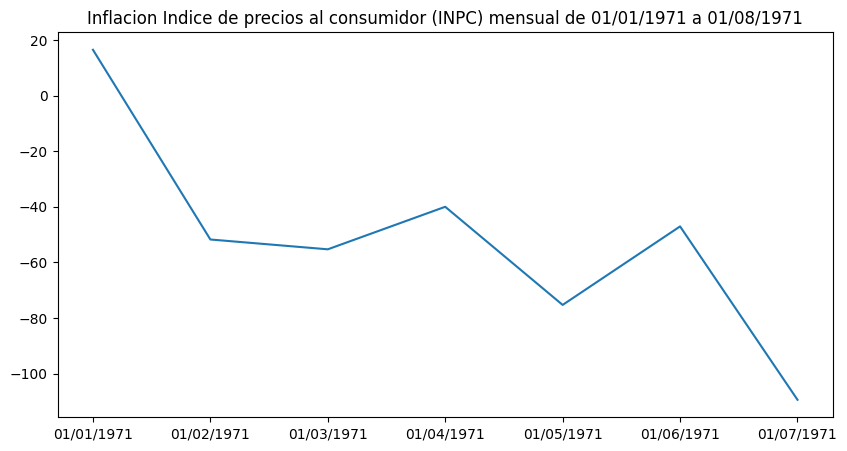

In [58]:
# Print Inflacion indice de precios al consumidor
num = 7
plt.figure(figsize=(10,5))
fecha_inicial = df['Fecha'][0]
fecha_final = df['Fecha'][num]

fecha = df['Fecha'][0:num]
inflacion = df[columnas[1]][0:num]
plt.plot(fecha, inflacion,)
plt.title(str(columnas[1])+" de "+str(fecha_inicial)+" a "+str(fecha_final))
plt.show()


"In order to train the NN we used a database provided by the Bank
of Mexico which contains monthly inflation, annual inflation
and annual inflation expected according to inflation measured
each month. January inflation is used as the input vector and
annual inflation as the target vector. Expected inflation is used
to compare NN results with the Bank of Mexico expectations"

In [59]:
INPC_mensual = df[columnas[1]]
INPC_acumulada = df[columnas[2]]
INPC_anual = df[columnas[3]]
Inflacion_subyacente_mensual = df[columnas[4]]
Inflacion_subyacente_acumulada = df[columnas[5]]
Inflacion_subyacente_anual = df[columnas[6]]
Inflacion_no_subyacente_mensual = df[columnas[7]]
Inflacion_no_subyacente_acumulada = df[columnas[8]]
Inflacion_no_subyacente_anual = df[columnas[9]]
fecha = df['Fecha']

In [60]:
eneros = list()
for f in fecha:
    anio = f.split('/')[2]
    anio = int(anio)
    mes = f.split('/')[1]
    mes = int(mes)
    # Seleccionar datos a partir de 1984
    if anio >= 1984:
        # Seleccionamos los eneros
        if mes == 1:
            eneros.append(f)

In [61]:
# Seleccionar los datos de enero
df_eneros = df[df['Fecha'].isin(eneros)]
df_eneros = df_eneros.reset_index(drop=True)
df_eneros.head()

,Fecha,Inflacion Indice de precios al consumidor (INPC) mensual,Inflacion Indice de precios al consumidor (INPC) acumulada en el anio,Inflacion Indice de precios al consumidor (INPC) anual,Inflacion subyacente mensual,Inflacion subyacente acumulada en el año,Inflacion subyacente anual,Inflacion no subyacente mensual,Inflacion no subyacente acumulada en el año,Inflacion no subyacente anual
0,01/01/1984,48.364486,-92.139143,-9.135925,22.99,-93.82,-12.36,144.28,-84.46,3.77
1,01/01/1985,74.588235,-87.457742,2.687627,24.41,-91.17,-0.27,245.39,-74.21,12.82
2,01/01/1986,29.809104,-86.133333,3.403922,92.15,-86.02,8.32,-36.29,-86.58,-10.93
3,01/01/1987,2.531646,-92.340426,-1.333333,7.65,-92.31,-0.49,-13.23,-92.50,-4.21
4,01/01/1988,4.671632,-90.287114,11.095056,6.02,-91.64,7.40,-0.99,-85.89,23.43


La forma en que los datos están estruturados es que cada entrada corresponde a un mes por cada entrada. Debido al gran número de datos faltantes tomaremos datos a partir de 01/01/1984

Haremos una ligera variación a lo que hace el articulo y tomaremos desde 1984 al 2021. Y compararemos las predicciones del 2021 al 2023.

Tomaremos los datos de enero como Inflacion Indice de precios al consumidor (INPC) mensual, Inflacion Indice de precios al consumidor (INPC) acumulada en el anio, Inflacion subyacente mensual,Inflacion subyacente acumulada en el año, Inflacion subyacente anual,Inflacion no subyacente mensual,Inflacion no subyacente acumulada en el año, Inflacion no subyacente anual como features y la Inflacion Indice de precios al consumidor (INPC) anual como target.


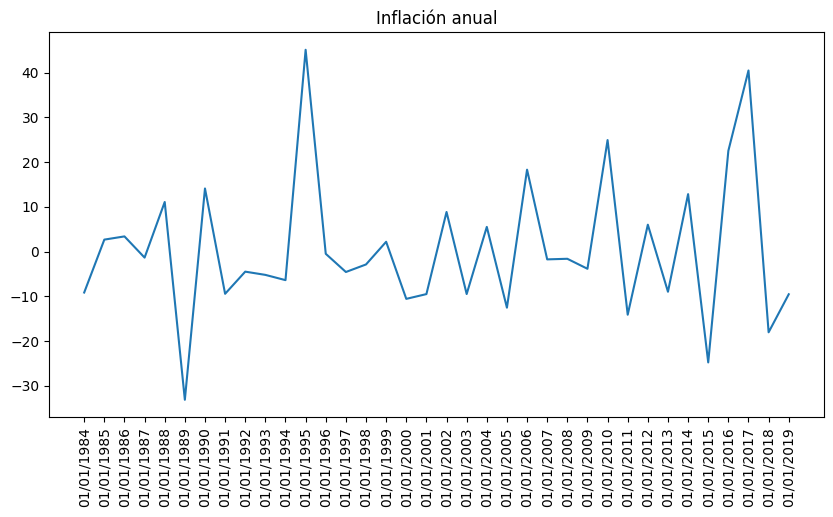

In [62]:
# Nuestro objetivo es predecir la inflación anual
# Seleccionamos la inflación anual
inflacion_anual = df_eneros[columnas[3]]
inflacion_anual = inflacion_anual[0:36]
fecha = df_eneros['Fecha']
fecha = fecha[0:36]
plt.figure(figsize=(10,5))
plt.plot(fecha, inflacion_anual)
plt.title("Inflación anual")
plt.xticks(rotation=90)
plt.show()

In [63]:
# Normalizar los datos
inflacion_anual = np.array(inflacion_anual)
inflacion_anual = inflacion_anual.reshape(-1, 1)
# Definir y con:
#INPC_anual = df[columnas[3]]
y = inflacion_anual
# Definir X con:
#INPC_mensual = df[columnas[1]]
#INPC_acumulada = df[columnas[2]]
#Inflacion_subyacente_mensual = df[columnas[4]]
#Inflacion_subyacente_acumulada = df[columnas[5]]
#Inflacion_subyacente_anual = df[columnas[6]]
#Inflacion_no_subyacente_mensual = df[columnas[7]]
#Inflacion_no_subyacente_acumulada = df[columnas[8]]
#Inflacion_no_subyacente_anual = df[columnas[9]]
X = np.array(df_eneros[[columnas[1], columnas[2], columnas[4], columnas[5], columnas[6], columnas[7], columnas[8], columnas[9]]])
# Normalizar los datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Convertir a tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

"So database will contain annual inflation values from 1970 to 1993
and the selected NN model will be used to forecast inflation
from 1994 to 2010. From the database, 70% of data will be
used to train the NN and the remain 30% will be used to
measure its performance according to the mean square error
(MSE). The NN model with the least MSE will be selected to
forecast inflation. The activation function used in the hidden
layers was the hyperbolic tangent and the rest of the
specifications were set to default Matlab values."

In [64]:
#Crear el modelo
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [65]:
    
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
epochs = 150

for i in range(epochs):
    for seq, labels in zip(x, y):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')



epoch:   1 loss: 339.80090332
epoch:  26 loss: 461.08773804
epoch:  51 loss: 8.30198860
epoch:  76 loss: 0.53088790
epoch: 101 loss: 1.14709640
epoch: 126 loss: 0.29072618


In [66]:
# Creamos el modelo en pytorch